<blockquote>
    <h1>Exercise 7.7</h1>
    <p>The <code>Wage</code> data set contains a number of other features not explored in this chapter, such as marital status ($\mathrm{maritl}$), job class ($\mathrm{jobclass}$), and others. Explore the relationships between some of these other predictors and $\mathrm{wage}$, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.</p>
</blockquote>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%run ../../customModules/usefulFunctions.ipynb
# https://stackoverflow.com/questions/34398054/ipython-notebook-cell-multiple-outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression

In [2]:
def plotWrapper(df_X, df_Y, degrees, replace_map):
    df_X_withIntercept = df_X.copy()
    independent = df_X_withIntercept.columns[0]
    polynomialMap = {independent: 1}
    for i in range(2, degrees + 1):
        variable_name = independent + str(i)
        df_X_withIntercept[variable_name] = df_X_withIntercept[independent]**i
        polynomialMap[variable_name] = i

    df_X_withIntercept.insert(0, 'Intercept', 1)
    fitted = sm.OLS(df_Y, df_X_withIntercept).fit()

    createPolynomialLinearRegressionPlot(df_X_withIntercept, df_Y, fitted_model=fitted, height=6, width=8, polynomialMap=polynomialMap)
    ax = plt.gca()
    sorted_keys = [key for key in sorted(replace_map[independent])]
    sorted_labels_mapping = [replace_map[independent][key] for key in sorted(replace_map[independent])]
    _ = ax.set_xticks(sorted_keys)
    _ = ax.set_xticklabels(sorted_labels_mapping)

In [3]:
df = pd.read_csv("../../DataSets/Wage/Wage.csv")
df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


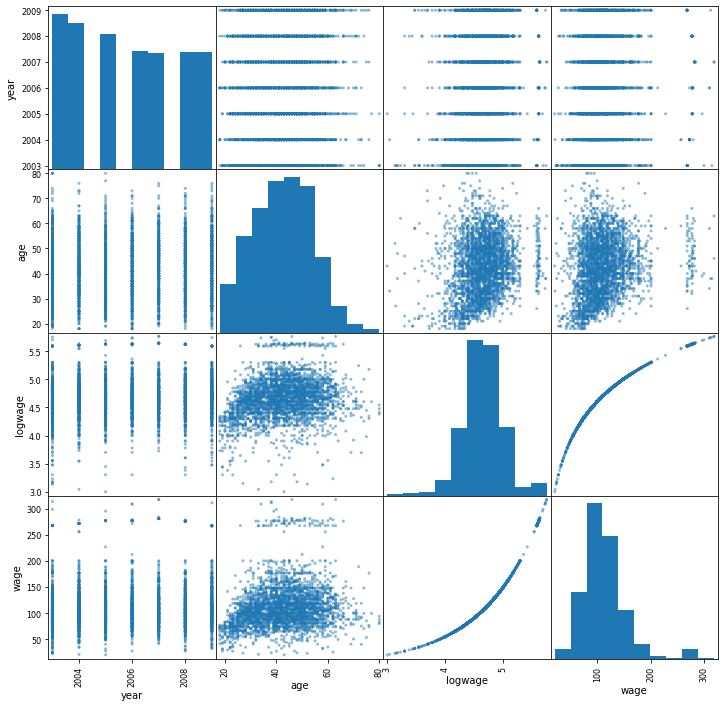

In [4]:
_ = pd.plotting.scatter_matrix(df, figsize=(12, 12))

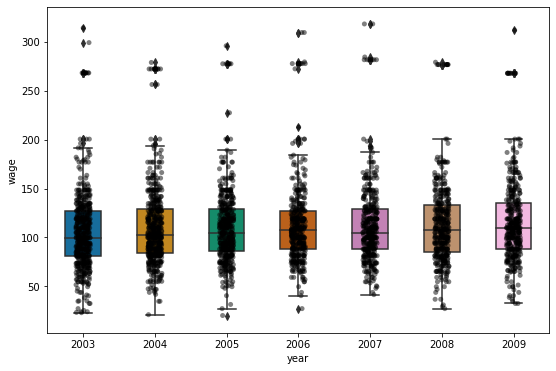

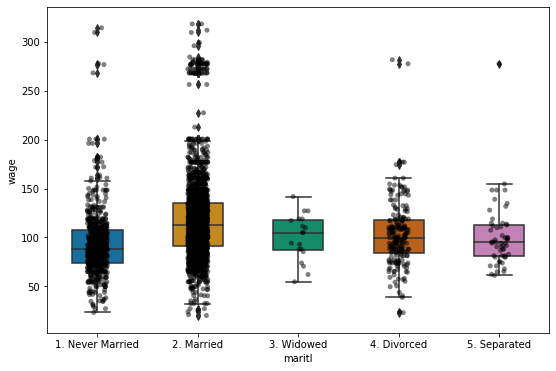

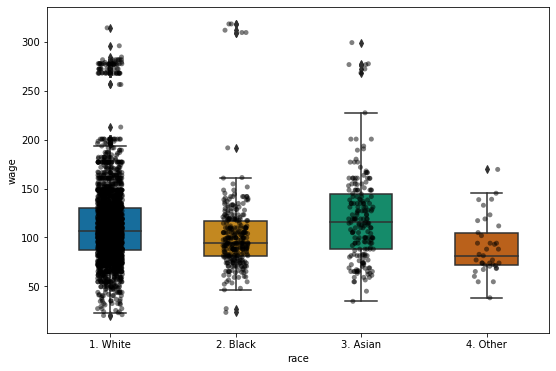

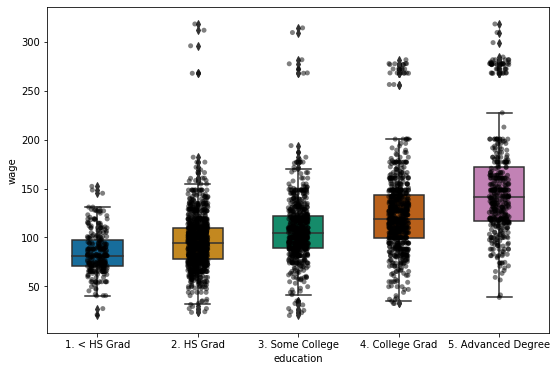

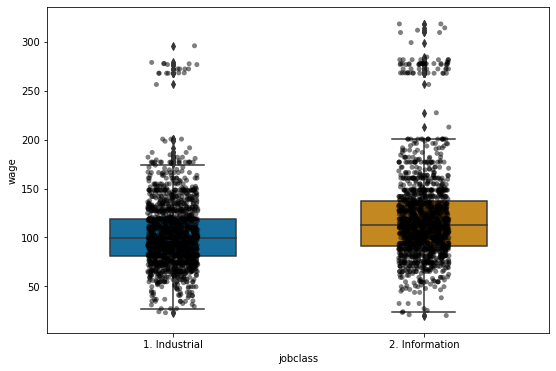

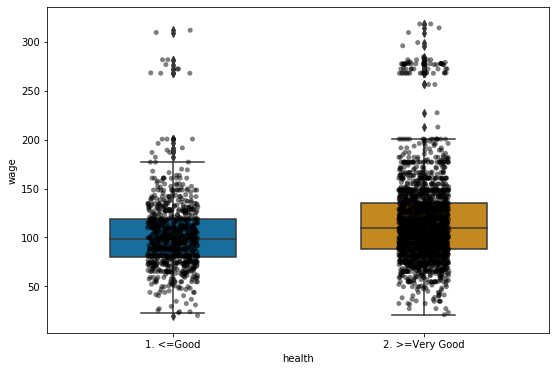

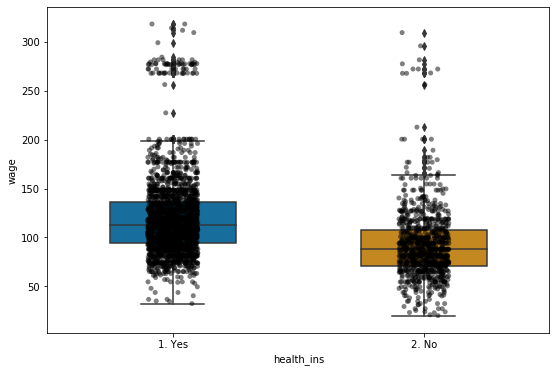

In [5]:
selectedColumns = ['year', 'maritl', 'race', 'education', 'jobclass', 'health', 'health_ins']
for index, column in enumerate(selectedColumns):
    _ = plt.figure(index, figsize=(9, 6))
    # http://cmdlinetips.com/2018/03/how-to-make-boxplots-in-python-with-pandas-and-seaborn/
    # make boxplot with Seaborn
    order = np.sort(df[column].unique())
    _ = sns.boxplot(y='wage', x=column, data=df, width=0.5, palette="colorblind", 
                    order=order)
    # add stripplot to boxplot with Seaborn
    _ = sns.stripplot(y='wage', x=column, data=df, jitter=True, marker='o', 
                          alpha=0.5, color='black', order=order)

From these plots, it appears the variables $\mathrm{maritl}$, $\mathrm{race}$ and $\mathrm{education}$ have the most discernible relationship with $\mathrm{wage}$ and warrant further investigation.

In [6]:
df_x = df[['maritl', 'race', 'education']].astype('category')
df_y = df[['wage']]

replace_map = {}
columns = df_x.columns
for column in columns:
    column_map = dict(enumerate(df_x[column].cat.categories))
    replace_map[column] = column_map
    df_x[column] = df_x[column].cat.codes
    
replace_map

{'maritl': {0: '1. Never Married',
  1: '2. Married',
  2: '3. Widowed',
  3: '4. Divorced',
  4: '5. Separated'},
 'race': {0: '1. White', 1: '2. Black', 2: '3. Asian', 3: '4. Other'},
 'education': {0: '1. < HS Grad',
  1: '2. HS Grad',
  2: '3. Some College',
  3: '4. College Grad',
  4: '5. Advanced Degree'}}

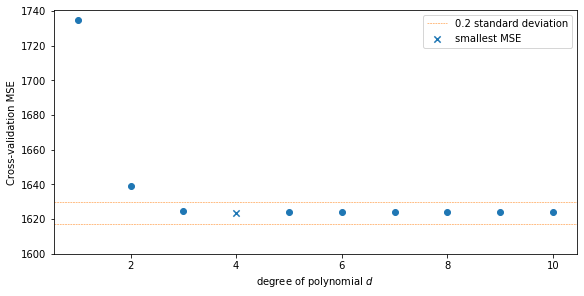

In [7]:
polynomialRegressionChooseOptimalDegree(df_x[['maritl']], df_y, total_degrees=10)

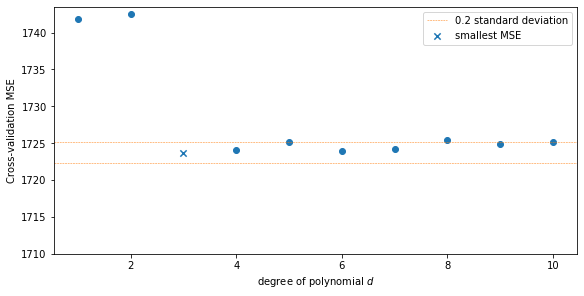

In [8]:
polynomialRegressionChooseOptimalDegree(df_x[['race']], df_y, total_degrees=10)

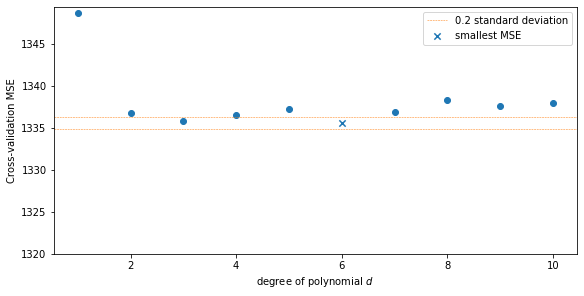

In [9]:
polynomialRegressionChooseOptimalDegree(df_x[['education']], df_y, total_degrees=10)

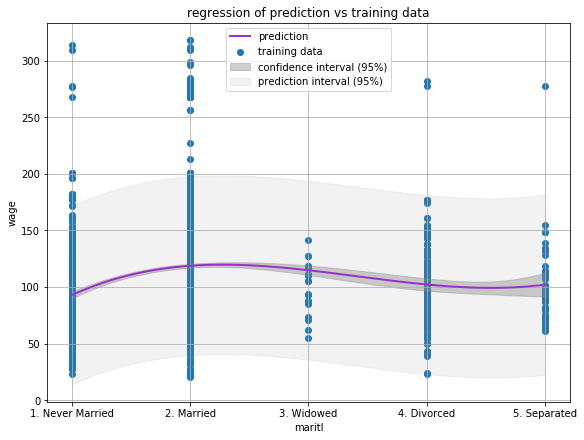

In [10]:
plotWrapper(df_x[['maritl']], df_y, degrees=3, replace_map=replace_map)

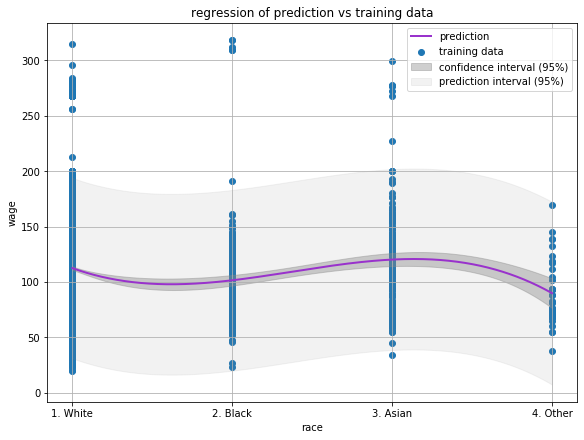

In [11]:
plotWrapper(df_x[['race']], df_y, degrees=3, replace_map=replace_map)

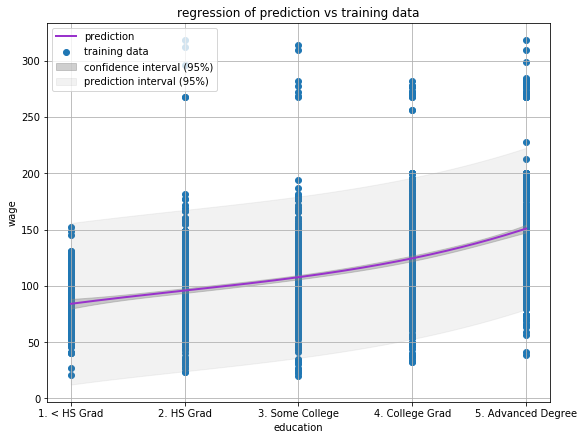

In [12]:
plotWrapper(df_x[['education']], df_y, degrees=3, replace_map=replace_map)

<p>Let us now obtain the test MSE of a polynomial GAM of the form
$$
y_i = \beta_0 + \beta_1 \mathrm{maritl} + \beta_2 \mathrm{maritl}^2 + \beta_3 \mathrm{maritl}^3 + \beta_4 \mathrm{race} + \beta_5 \mathrm{race}^2 + \beta_6 \mathrm{race}^3 + \beta_7 \mathrm{education} + \beta_8 \mathrm{education}^2 + \beta_9 \mathrm{education}^3
$$</p>

In [13]:
total_degrees = 3
columns = df_x.columns
for independent in columns:
    for i in range(2, total_degrees + 1):
        variable_name = independent + str(i)
        df_x[variable_name] = df_x[independent]**i

df_x = df_x.reindex(sorted(df_x.columns), axis=1)
df_x = df_x.astype('category')

descriptiveColumns = df_x.columns.tolist()
loocv = LeaveOneOut() # LeaveOneOut
MSE = 0
for train_index, test_index in loocv.split(df_x):
    df_x_train, df_x_test = df_x[descriptiveColumns].iloc[train_index], df_x[descriptiveColumns].iloc[test_index]
    df_y_train, df_y_test = df_y.iloc[train_index], df_y.iloc[test_index]

    model = LinearRegression()
    _ = model.fit(df_x_train, df_y_train)

    Y_pred = model.predict(df_x_test)
    MSE += (df_y_test.iloc[0, 0] - Y_pred[0, 0])**2        

MSE / df_x.shape[0]

1251.8386263447733

In [14]:
model = LinearRegression()
lin_reg = model.fit(df_x, df_y)  # fit model on entire data set
pd.DataFrame(lin_reg.coef_, columns=descriptiveColumns)

,education,education2,education3,maritl,maritl2,maritl3,race,race2,race3
0,12.867363,-1.880679,0.672086,42.381708,-23.969033,3.608244,-6.915907,4.266561,-0.97649


<p>Thus, we see that the polynomial GAM has the smallest test MSE of all the models tested above.</p>